In [5]:
import numpy as np
import pandas as pd
import os
import glob
import re
import difflib
from collections import defaultdict

In [6]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

# Root folder where subfolders of parquet files live
root_folder = r'C:\Users\omidw\Desktop\py\TennisSchema\20240331\data\raw'
cleaned_folder = os.path.join(root_folder, "cleaned")
os.makedirs(cleaned_folder, exist_ok=True)

In [7]:
# Schema (types) derived from the PDF (normalized keys are lowercase/stripped)
schema_types = {
    # MatchHome/Away Team Info (subfolder 1)
    "match_id": "int", "name": "str", "slug": "str", "gender": "str", "user_count": "int",
    "residence": "str", "birthplace": "str", "height": "float", "weight": "int",
    "plays": "str", "turned_pro": "int", "current_prize": "int", "total_prize": "int",
    "player_id": "int", "current_rank": "int", "name_code": "str", "country": "str", "full_name": "str",

    # OddsInfo (subfolder 2)
    "market_id": "int", "market_name": "str", "is_live": "bool", "suspended": "bool",
    "initial_fractional_value": "str", "fractional_value": "str", "choice_name": "str",
    "choice_source_id": "int", "winnig": "bool", "change": "int",  # note: 'winnig' spelled in schema

    # GameInfo (subfolder 3)
    "set_id": "int", "game_id": "int", "point_id": "int", "home_point": "str", "away_point": "str",
    "point_description": "int", "home_point_type": "int", "away_point_type": "int",
    "home_score": "int", "away_score": "int", "serving": "str", "scoring": "str",

    # Period / Statistic (subfolder 4)
    "period": "str", "statistic_category_name": "str", "statistic_name": "str",
    "home_stat": "str", "away_stat": "str", "compare_code": "int",
    "statistic_type": "str", "value_type": "str", "home_value": "int", "away_value": "int",
    "home_total": "int", "away_total": "int",

    # PowerInfo (subfolder 5)
    "set_num": "int", "game_num": "int", "value": "float", "break_occurred": "bool",

    # MatchVotesInfo (subfolder 6)
    "home_vote": "int", "away_vote": "int",

    # Common event fields
    "match_slug": "str", "final_result_only": "bool", "start_datetime": "int",
    "winner_code": "int", "first_to_serve": "int", "default_period_count": "int",
    "tournament_name": "str", "tournament_id": "int", "year": "int", "round_id": "int",
    "city": "str", "stadium": "str", "venue_id": "int",
    "normal_time": "int",
}

# normalize schema keys for matching
schema_norm = {k.strip().lower(): v for k, v in schema_types.items()}

# helper: show schema keys (for debugging)
# print(sorted(schema_norm.keys()))

#

In [8]:
# Utility functions
def normalize_colname(name):
    """Lower, strip and remove extra chars for fuzzy matching."""
    if name is None:
        return ""
    s = str(name).strip().lower()
    s = re.sub(r"[^\w]+", "_", s)  # replace non-word with underscore
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def best_match_col(name, schema_keys, cutoff=0.7):
    """
    Find best matching schema key for a column name using difflib.
    Returns None if no good match.
    """
    name_norm = normalize_colname(name)
    # try exact normalized match first
    if name_norm in schema_keys:
        return name_norm
    # fallback to difflib close matches
    candidates = difflib.get_close_matches(name_norm, schema_keys, n=1, cutoff=cutoff)
    return candidates[0] if candidates else None

number_regex = re.compile(r"[-+]?\d*\.?\d+")

def extract_number(value):
    """Try to extract a number from strings, or return np.nan."""
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float, np.number)):
        # convert to float for safe mean calculations
        try:
            return float(value)
        except:
            return np.nan
    s = str(value).strip()
    m = number_regex.search(s)
    if m:
        try:
            return float(m.group())
        except:
            return np.nan
    return np.nan

def clean_numeric_series(s, to_int=False):
    parsed = s.map(extract_number)
    mean_value = parsed.mean(skipna=True)
    if np.isnan(mean_value):
        mean_value = 0.0
    cleaned = parsed.fillna(mean_value).replace([np.inf, -np.inf], mean_value)
    if to_int:
        # round before cast (you can change rounding policy if needed)
        return cleaned.round().astype(np.int64)
    else:
        return cleaned.astype(np.float64)

def clean_bool_series(s):
    # map common textual values
    if s.dtype == object:
        mapped = s.astype(str).str.strip().str.lower().map({
            "true": True, "false": False, "1": True, "0": False,
            "yes": True, "no": False, "y": True, "n": False, "t": True, "f": False
        })
        return mapped.fillna(False).astype(bool)
    else:
        return s.fillna(False).astype(bool)

def clean_str_series(s):
    return s.fillna("unknown").astype(str)


In [9]:
combined_cleaned = []
per_folder_reports = {}

schema_keys = set(schema_norm.keys())

for subfolder in sorted(os.listdir(root_folder)):
    subfolder_path = os.path.join(root_folder, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    # read parquet files inside this subfolder
    parquet_files = glob.glob(os.path.join(subfolder_path, "*.parquet"))
    if not parquet_files:
        continue

    print(f"\n--- Processing folder: {subfolder} ({len(parquet_files)} parquet files) ---")
    parts = [pd.read_parquet(p) for p in parquet_files]
    df_part = pd.concat(parts, ignore_index=True)
    original_cols = list(df_part.columns)
    print("Original columns:", original_cols)

    # Build rename mapping: try to match each col to schema_norm
    rename_map = {}
    unmatched = []
    for col in original_cols:
        match = best_match_col(col, schema_keys, cutoff=0.75)
        if match:
            rename_map[col] = match
        else:
            unmatched.append(col)

    # If there are many unmatched, relax cutoff and try again
    if unmatched:
        for col in unmatched[:]:
            match = best_match_col(col, schema_keys, cutoff=0.55)
            if match:
                rename_map[col] = match
                unmatched.remove(col)

    # apply renaming *temporarily* to a working copy where column names are canonical schema keys when possible
    df_work = df_part.rename(columns=rename_map)

    # ---------------------------
    # Handle duplicate column labels that may arise when multiple original columns map to same schema key.
    # For each duplicated label we coalesce columns: take the first non-null value across duplicates (bfill axis=1).
    # ---------------------------
    dup_labels = df_work.columns[df_work.columns.duplicated()].unique()
    if len(dup_labels) > 0:
        print("  NOTE: duplicate column labels detected after rename:", list(dup_labels))
        for lbl in dup_labels:
            # select all columns with this label (returns a DataFrame)
            df_sub = df_work.loc[:, df_work.columns == lbl]
            # take first non-null value across the row (bfill then first column)
            merged = df_sub.bfill(axis=1).iloc[:, 0]
            # drop all columns with this label
            df_work = df_work.loc[:, df_work.columns != lbl]
            # assign merged series back under the single label
            df_work[lbl] = merged
        # try to preserve a reasonable column order: keep original order where possible
        new_order = []
        for c in original_cols:
            if c in df_work.columns and c not in new_order:
                new_order.append(c)
        # append any remaining columns that weren't in original order
        for c in df_work.columns:
            if c not in new_order:
                new_order.append(c)
        df_work = df_work.loc[:, new_order]

    # sanity check: no duplicated columns remain
    if df_work.columns.duplicated().any():
        print("ERROR: duplicate columns still present after merge:", df_work.columns[df_work.columns.duplicated()].tolist())
        # defensive: deduplicate by keeping first occurrence
        df_work = df_work.loc[:, ~df_work.columns.duplicated()]

    # cleaning per column based on schema if available, else autodetect
    cols_after = list(df_work.columns)
    print("Columns after tentative rename & dedup:", cols_after)

    report = {"original_cols": original_cols, "rename_map": rename_map.copy(), "cleaned_types": {}, "unknown_counts": {}}

    for col in cols_after:
        key = col.strip().lower()  # already normalized keys from rename_map or original col if not renamed
        forced_type = schema_norm.get(key, None)  # None => autodetect

        # get a single Series (guaranteed now)
        series = df_work[col]

        # If forced_type present, use that; otherwise auto-detect by trying numeric parse ratio
        if forced_type == "int":
            cleaned = clean_numeric_series(series, to_int=True)
            df_work[col] = cleaned
            report["cleaned_types"][col] = "int"
        elif forced_type == "float":
            cleaned = clean_numeric_series(series, to_int=False)
            df_work[col] = cleaned
            report["cleaned_types"][col] = "float"
        elif forced_type == "bool":
            cleaned = clean_bool_series(series)
            df_work[col] = cleaned
            report["cleaned_types"][col] = "bool"
        elif forced_type == "str":
            cleaned = clean_str_series(series)
            df_work[col] = cleaned
            report["cleaned_types"][col] = "str"
        else:
            # auto-detect:
            parsed = series.map(extract_number)
            parsable = parsed.notna().sum()
            frac = parsable / max(1, len(series))
            if frac >= 0.05:
                # treat as numeric float (keep as float for safety)
                cleaned = clean_numeric_series(series, to_int=False)
                df_work[col] = cleaned
                report["cleaned_types"][col] = "auto_float"
            elif pd.api.types.is_bool_dtype(series):
                cleaned = clean_bool_series(series)
                df_work[col] = cleaned
                report["cleaned_types"][col] = "auto_bool"
            else:
                cleaned = clean_str_series(series)
                df_work[col] = cleaned
                report["cleaned_types"][col] = "auto_str"

        # track unknown counts for strings (or NaNs for numeric/bool)
        if df_work[col].dtype == object:
            unknown_cnt = (df_work[col] == "unknown").sum()
            report["unknown_counts"][col] = int(unknown_cnt)
        else:
            nan_cnt = int(df_work[col].isna().sum())
            report["unknown_counts"][col] = nan_cnt

    # Save per-subfolder cleaned dataframe (keep original column names but updated values)
    # Build inverse rename for columns we changed: schema_key -> original_col_name (first original that mapped)
    inverse_rename = {}
    for orig, schema_key in rename_map.items():
        # if multiple original map to same schema key, keep first
        inverse_rename[schema_key] = inverse_rename.get(schema_key, orig)

    # create df_out with original column names where mapping existed, else keep column name
    df_out = df_work.rename(columns={schema_key: orig_name for schema_key, orig_name in inverse_rename.items()})

    out_file = os.path.join(cleaned_folder, f"{subfolder}_cleaned.parquet")
    df_out.to_parquet(out_file, index=False)
    print(f"Saved cleaned per-folder parquet: {out_file}  (shape: {df_out.shape})")

    per_folder_reports[subfolder] = report

    combined_cleaned.append(df_out)  # gather for combined file



--- Processing folder: cleaned (6 parquet files) ---
Original columns: ['match_id', 'name', 'slug', 'gender', 'user_count', 'residence', 'birthplace', 'height', 'weight', 'plays', 'turned_pro', 'current_prize', 'total_prize', 'player_id', 'current_rank', 'name_code', 'country', 'full_name', 'period_1_tie_break', 'period_2_tie_break', 'period_3_tie_break', 'period_4_tie_break', 'period_5_tie_break', 'normal_time', 'first_to_serve', 'winner_code', 'default_period_count', 'start_datetime', 'match_slug', 'final_result_only', 'round_id', 'year', 'tournament_id', 'tournament_name', 'has_event_player_statistics', 'crowd_sourcing_enabled', 'has_performance_graph_feature', 'display_inverse_home_away_teams', 'city', 'stadium', 'venue_id', 'display_score', 'home_team_seed', 'away_team_seed', 'tennis_points', 'competition_type', 'period_1', 'custom_id', 'market_id', 'market_name', 'is_live', 'suspended', 'initial_fractional_value', 'fractional_value', 'choice_name', 'choice_source_id', 'winnig', 

C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\1370971100.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return mapped.fillna(False).astype(bool)
C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\1370971100.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return mapped.fillna(False).astype(bool)
C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\1370971100.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

Saved cleaned per-folder parquet: C:\Users\omidw\Desktop\py\TennisSchema\20240331\data\raw\cleaned\cleaned_cleaned.parquet  (shape: (74007, 81))

--- Processing folder: raw_match_parquet (6259 parquet files) ---


C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\707415501.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_part = pd.concat(parts, ignore_index=True)


Original columns: ['match_id', 'name', 'slug', 'gender', 'user_count', 'residence', 'birthplace', 'height', 'weight', 'plays', 'turned_pro', 'current_prize', 'total_prize', 'player_id', 'current_rank', 'name_code', 'country', 'full_name', 'current_score', 'display_score', 'period_1', 'period_2', 'period_3', 'period_4', 'period_5', 'period_1_tie_break', 'period_2_tie_break', 'period_3_tie_break', 'period_4_tie_break', 'period_5_tie_break', 'normal_time', 'first_to_serve', 'home_team_seed', 'away_team_seed', 'custom_id', 'winner_code', 'default_period_count', 'start_datetime', 'match_slug', 'final_result_only', 'round_id', 'cup_round_type', 'season_id', 'year', 'current_period_start_timestamp', 'tournament_id', 'tournament_name', 'tournament_slug', 'tournament_unique_id', 'tournament_category_name', 'tournament_category_slug', 'ground_type', 'tennis_points', 'has_event_player_statistics', 'crowd_sourcing_enabled', 'has_performance_graph_feature', 'display_inverse_home_away_teams', 'prior

C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\707415501.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged = df_sub.bfill(axis=1).iloc[:, 0]
C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\707415501.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged = df_sub.bfill(axis=1).iloc[:, 0]
C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\707415501.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to 

Columns after tentative rename & dedup: ['match_id', 'name', 'slug', 'gender', 'user_count', 'residence', 'birthplace', 'height', 'weight', 'plays', 'turned_pro', 'current_prize', 'total_prize', 'player_id', 'current_rank', 'name_code', 'country', 'full_name', 'period_1_tie_break', 'period_2_tie_break', 'period_3_tie_break', 'period_4_tie_break', 'period_5_tie_break', 'normal_time', 'first_to_serve', 'winner_code', 'default_period_count', 'start_datetime', 'match_slug', 'final_result_only', 'round_id', 'year', 'tournament_id', 'tournament_name', 'has_event_player_statistics', 'crowd_sourcing_enabled', 'has_performance_graph_feature', 'display_inverse_home_away_teams', 'city', 'stadium', 'venue_id', 'away_score', 'home_vote', 'away_vote', 'home_point', 'home_point_type', 'period', 'set_id']
Saved cleaned per-folder parquet: C:\Users\omidw\Desktop\py\TennisSchema\20240331\data\raw\cleaned\raw_match_parquet_cleaned.parquet  (shape: (6259, 48))

--- Processing folder: raw_odds_parquet (355

C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\1370971100.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return mapped.fillna(False).astype(bool)


Original columns: ['match_id', 'set_id', 'game_id', 'point_id', 'home_point', 'away_point', 'point_description', 'home_point_type', 'away_point_type', 'home_score', 'away_score', 'serving', 'scoring']
Columns after tentative rename & dedup: ['match_id', 'set_id', 'game_id', 'point_id', 'home_point', 'away_point', 'point_description', 'home_point_type', 'away_point_type', 'home_score', 'away_score', 'serving', 'scoring']
Saved cleaned per-folder parquet: C:\Users\omidw\Desktop\py\TennisSchema\20240331\data\raw\cleaned\raw_point_by_point_parquet_cleaned.parquet  (shape: (37931, 13))

--- Processing folder: raw_statistics_parquet (369 parquet files) ---
Original columns: ['match_id', 'period', 'statistic_category_name', 'statistic_name', 'home_stat', 'away_stat', 'compare_code', 'statistic_type', 'value_type', 'home_value', 'away_value', 'home_total', 'away_total']
Columns after tentative rename & dedup: ['match_id', 'period', 'statistic_category_name', 'statistic_name', 'home_stat', 'awa

In [10]:
if combined_cleaned:
    final_df = pd.concat(combined_cleaned, ignore_index=True, sort=False)
    print("🔄 Combined shape before type-fix:", final_df.shape)

    # تبدیل نوع داده‌ها بر اساس اسکیما
    for col in final_df.columns:
        key = col.strip().lower()
        forced_type = schema_norm.get(key, None)

        if forced_type == "int":
            final_df[col] = pd.to_numeric(final_df[col], errors="coerce")
            mean_val = final_df[col].mean(skipna=True)
            if pd.isna(mean_val):
                mean_val = 0
            final_df[col] = final_df[col].fillna(mean_val).astype("int64")

        elif forced_type == "float":
            final_df[col] = pd.to_numeric(final_df[col], errors="coerce")
            mean_val = final_df[col].mean(skipna=True)
            if pd.isna(mean_val):
                mean_val = 0.0
            final_df[col] = final_df[col].fillna(mean_val).astype("float64")

        elif forced_type == "bool":
            final_df[col] = (
                final_df[col]
                .astype(str)
                .str.strip()
                .str.lower()
                .map({"true": True, "1": True, "false": False, "0": False})
            )
            final_df[col] = final_df[col].fillna(False).astype(bool)

        else:  # پیش‌فرض str
            final_df[col] = final_df[col].astype(str).fillna("unknown")

    # ذخیره خروجی نهایی
    final_out = os.path.join(root_folder, "cleaned_data.parquet")
    final_df.to_parquet(final_out, index=False)
    print("\n✅ Saved combined cleaned dataframe:", final_out)
    print("📊 Combined shape after type-fix:", final_df.shape)

else:
    print("No data processed!")

# %%
# Summary report (per-folder)
for folder, rep in per_folder_reports.items():
    print(f"\n--- Report for folder: {folder} ---")
    print("Original cols:", rep["original_cols"])
    print("Rename map:", rep["rename_map"])
    print("Cleaned types (sample):")
    for k, v in list(rep["cleaned_types"].items())[:10]:
        print(" ", k, "->", v)
    print("Unknown / NaN counts (sample):")
    for k, v in list(rep["unknown_counts"].items())[:10]:
        print(" ", k, ":", v)

🔄 Combined shape before type-fix: (148014, 88)


C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\2968192882.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df[col] = final_df[col].fillna(False).astype(bool)
C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\2968192882.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df[col] = final_df[col].fillna(False).astype(bool)
C:\Users\omidw\AppData\Local\Temp\ipykernel_13144\2968192882.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects


✅ Saved combined cleaned dataframe: C:\Users\omidw\Desktop\py\TennisSchema\20240331\data\raw\cleaned_data.parquet
📊 Combined shape after type-fix: (148014, 88)

--- Report for folder: cleaned ---
Original cols: ['match_id', 'name', 'slug', 'gender', 'user_count', 'residence', 'birthplace', 'height', 'weight', 'plays', 'turned_pro', 'current_prize', 'total_prize', 'player_id', 'current_rank', 'name_code', 'country', 'full_name', 'period_1_tie_break', 'period_2_tie_break', 'period_3_tie_break', 'period_4_tie_break', 'period_5_tie_break', 'normal_time', 'first_to_serve', 'winner_code', 'default_period_count', 'start_datetime', 'match_slug', 'final_result_only', 'round_id', 'year', 'tournament_id', 'tournament_name', 'has_event_player_statistics', 'crowd_sourcing_enabled', 'has_performance_graph_feature', 'display_inverse_home_away_teams', 'city', 'stadium', 'venue_id', 'display_score', 'home_team_seed', 'away_team_seed', 'tennis_points', 'competition_type', 'period_1', 'custom_id', 'mark

In [11]:
# Quick checks for troublesome columns across final_df (if created)
try:
    # check height parseability
    if 'height' in final_df.columns:
        parsed = final_df['height'].map(lambda x: extract_number(x) if not pd.isna(x) else np.nan)
        parsable = parsed.notna().sum()
        print("\nHeight parsable:", parsable, "/", len(final_df))
        print(final_df['height'].describe())

    # top unknown columns
    top_unknowns = {}
    for c in final_df.columns:
        if final_df[c].dtype == object:
            top_unknowns[c] = int((final_df[c] == "unknown").sum())
    if top_unknowns:
        print("\nTop columns with 'unknown' counts (sample 20):")
        for c, cnt in sorted(top_unknowns.items(), key=lambda x: x[1], reverse=True)[:20]:
            print(f"  {c}: {cnt}")
except NameError:
    pass

# %%
# End of notebook
print("\nDone. Per-folder cleaned files are in:", cleaned_folder)


Height parsable: 148014 / 148014
count    148014.000000
mean          1.819251
std           0.006562
min           1.570000
25%           1.819251
50%           1.819251
75%           1.819251
max           2.080000
Name: height, dtype: float64

Top columns with 'unknown' counts (sample 20):
  period_4_tie_break: 80266
  period_5_tie_break: 80266
  period_3_tie_break: 80230
  period_1_tie_break: 80142
  period_2_tie_break: 80118
  residence: 79840
  plays: 79500
  birthplace: 79332
  match_slug: 78764
  tournament_name: 78764
  city: 78764
  stadium: 78764
  gender: 78604
  name_code: 78602
  full_name: 78602
  slug: 78262
  country: 76974
  name: 76760
  market_name: 73237
  initial_fractional_value: 73237

Done. Per-folder cleaned files are in: C:\Users\omidw\Desktop\py\TennisSchema\20240331\data\raw\cleaned


In [12]:
root_folder = r'C:\Users\omidw\Desktop\py\TennisSchema\20240331\data\raw'
cleaned_folder = os.path.join(root_folder, "cleaned")

# پیدا کردن همه فایل‌های _cleaned.parquet
files = sorted(glob.glob(os.path.join(cleaned_folder, "*_cleaned.parquet")))

if not files:
    raise SystemExit("هیچ فایل *_cleaned.parquet در پوشه cleaned پیدا نشد: " + cleaned_folder)

print("Found cleaned files (count={}):".format(len(files)))
for f in files:
    print(" -", os.path.basename(f))

# خواندن و ادغام فایل‌ها
dfs = []
for f in files:
    print(f"Reading {os.path.basename(f)} ...")
    df_part = pd.read_parquet(f)
    print("  shape:", df_part.shape)
    dfs.append(df_part)

print("\nConcatenating ...")
merged = pd.concat(dfs, ignore_index=True, sort=False)
print("Merged shape:", merged.shape)

# چند بررسی سریع
print("\nColumns (sample):", merged.columns.tolist()[:40])
print("\nHead of merged dataframe:")
display(merged.head(5))

# شمارش 'unknown' در ستون‌های متنی (اختیاری برای بررسی کیفیت)
unknown_counts = {c: int((merged[c] == "unknown").sum()) for c in merged.columns if merged[c].dtype == object}
if unknown_counts:
    print("\nTop columns with 'unknown' counts (sample):")
    for k, v in sorted(unknown_counts.items(), key=lambda x: x[1], reverse=True)[:15]:
        print(f"  {k}: {v}")

# ذخیره خروجی نهایی
out_path = os.path.join(root_folder, "cleaned_all_combined.parquet")
merged.to_parquet(out_path, index=False)
print("\n✅ Saved combined parquet to:", out_path)

Found cleaned files (count=7):
 - cleaned_cleaned.parquet
 - raw_match_parquet_cleaned.parquet
 - raw_odds_parquet_cleaned.parquet
 - raw_point_by_point_parquet_cleaned.parquet
 - raw_statistics_parquet_cleaned.parquet
 - raw_tennis_power_parquet_cleaned.parquet
 - raw_votes_parquet_cleaned.parquet
Reading cleaned_cleaned.parquet ...
  shape: (74007, 81)
Reading raw_match_parquet_cleaned.parquet ...
  shape: (6259, 48)
Reading raw_odds_parquet_cleaned.parquet ...
  shape: (770, 11)
Reading raw_point_by_point_parquet_cleaned.parquet ...
  shape: (37931, 13)
Reading raw_statistics_parquet_cleaned.parquet ...
  shape: (21243, 13)
Reading raw_tennis_power_parquet_cleaned.parquet ...
  shape: (7053, 5)
Reading raw_votes_parquet_cleaned.parquet ...
  shape: (751, 3)

Concatenating ...
Merged shape: (148014, 88)

Columns (sample): ['match_id', 'name', 'slug', 'gender', 'user_count', 'residence', 'birthplace', 'height', 'weight', 'plays', 'turned_pro', 'current_prize', 'total_prize', 'player_i

,match_id,name,slug,gender,user_count,residence,birthplace,height,weight,plays,turned_pro,current_prize,total_prize,player_id,current_rank,name_code,country,full_name,period_1_tie_break,period_2_tie_break,period_3_tie_break,period_4_tie_break,period_5_tie_break,normal_time,first_to_serve,winner_code,default_period_count,start_datetime,match_slug,final_result_only,round_id,year,tournament_id,tournament_name,has_event_player_statistics,crowd_sourcing_enabled,has_performance_graph_feature,display_inverse_home_away_teams,city,stadium,venue_id,market_id,market_name,is_live,suspended,initial_fractional_value,fractional_value,choice_name,choice_source_id,winnig,change,set_id,game_id,point_id,home_point,away_point,point_description,home_point_type,away_point_type,home_score,away_score,serving,scoring,period_1,statistic_category_name,statistic_name,home_stat,away_stat,compare_code,statistic_type,value_type,home_value,away_value,home_total,away_total,set_num,game_num,value,break_occurred,home_vote,away_vote,display_score,home_team_seed,away_team_seed,tennis_points,competition_type,custom_id,period
0,12156295,Rybakina E.,rybakina-elena,F,22673.0,unknown,"Moscow, Russia",1.84,76.0,right-handed,2016.0,1226279.0,11104942.0,186312.0,4.0,RYB,Kazakhstan,"Rybakina, Elena",unknown,unknown,unknown,unknown,unknown,0.0,1.0,1.0,3.0,1.711904e+09,unknown,False,9.0,2024.0,128397.0,unknown,0.0,0.0,0.0,0.0,unknown,unknown,29056.0,2.0,unknown,False,False,unknown,unknown,unknown,201639925.0,False,0.0,58784.0,5.0,3.0,unknown,unknown,0.0,2.0,3.0,3.0,1.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,2.0,unknown,unknown,9.0,9.0,19.0,19.0,2.0,5.0,-0.484384,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12157171,Sinner J.,sinner-jannik,M,92881.0,"Monte Carlo, Monaco","San Candido, Italy",1.88,68.0,right-handed,2018.0,3301073.0,17518144.0,206570.0,2.0,SIN,Italy,"Sinner, Jannik",unknown,unknown,unknown,unknown,unknown,0.0,1.0,1.0,3.0,1.711904e+09,unknown,False,9.0,2024.0,128397.0,unknown,0.0,0.0,0.0,0.0,unknown,unknown,29056.0,2.0,unknown,False,False,unknown,unknown,unknown,201639925.0,False,0.0,58784.0,5.0,3.0,unknown,unknown,0.0,2.0,3.0,3.0,1.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,2.0,unknown,unknown,9.0,9.0,19.0,19.0,2.0,5.0,-0.484384,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12173700,Martínez P.,martinez-pedro,M,3165.0,"Valencia, Spain","Alzira, Spain",1.85,76.0,right-handed,2016.0,94362.0,2787963.0,77223.0,77.0,MAR,Spain,"Martinez, Pedro",unknown,unknown,unknown,unknown,unknown,0.0,1.0,1.0,3.0,1.711904e+09,unknown,False,9.0,2024.0,128397.0,unknown,0.0,0.0,0.0,0.0,unknown,unknown,29056.0,2.0,unknown,False,False,unknown,unknown,unknown,201639925.0,False,0.0,58784.0,5.0,3.0,unknown,unknown,0.0,2.0,3.0,3.0,1.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,2.0,unknown,unknown,9.0,9.0,19.0,19.0,2.0,5.0,-0.484384,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12173714,Martínez P.,martinez-pedro,M,3050.0,"Valencia, Spain","Alzira, Spain",1.85,76.0,right-handed,2016.0,94362.0,2787963.0,77223.0,77.0,MAR,Spain,"Martinez, Pedro",unknown,unknown,unknown,unknown,unknown,0.0,1.0,1.0,3.0,1.711904e+09,unknown,False,9.0,2024.0,128397.0,unknown,0.0,0.0,0.0,0.0,unknown,unknown,29056.0,2.0,unknown,False,False,unknown,unknown,unknown,201639925.0,False,0.0,58784.0,5.0,3.0,unknown,unknown,0.0,2.0,3.0,3.0,1.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,2.0,unknown,unknown,9.0,9.0,19.0,19.0,2.0,5.0,-0.484384,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12173950,Nardi L.,nardi-luca,M,7432.0,unknown,Pesaro,1.85,76.0,right-handed,2011.0,123573.0,687717.0,289233.0,75.0,NAR,Italy,"Nardi, Luca",unknown,unknown,unknown,unknown,unknown,0.0,1.0,1.0,3.0,1.711904e+09,unknown,False,9.0,2024.0,128397.0,unknown,0.0,0.0,0.0,0.0,unknown,unknown,29056.0,2.0,unknown,False,False,unknown,unknown,unknown,201639925.0,False,0.0,58784.0,5.0,3.0,unknown,unknown,0.0,2.0,3.0,3.0,1.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,2.0,unknown,unknown,9.0,9.0,


Top columns with 'unknown' counts (sample):
  period_4_tie_break: 80266
  period_5_tie_break: 80266
  period_3_tie_break: 80230
  period_1_tie_break: 80142
  period_2_tie_break: 80118
  residence: 79840
  plays: 79500
  birthplace: 79332
  match_slug: 78764
  tournament_name: 78764
  city: 78764
  stadium: 78764
  gender: 78604
  name_code: 78602
  full_name: 78602

✅ Saved combined parquet to: C:\Users\omidw\Desktop\py\TennisSchema\20240331\data\raw\cleaned_all_combined.parquet


Builing The final dataframe

In [13]:
import pandas as pd
import os
import glob

# مسیر پوشه فایل‌های تمیز شده
input_folder = r"C:\Users\omidw\Desktop\Cleaned_data"
# مسیر ذخیره خروجی
output_file = r"C:\Users\omidw\Desktop\Cleaned_data\Cleaned_frame\final_cleaned_data.parquet"

# پیدا کردن همه فایل‌های پارکت
parquet_files = sorted(glob.glob(os.path.join(input_folder, "*.parquet")))

print(f"📂 Found {len(parquet_files)} parquet files")

# برای حجم بالا: به صورت مرحله‌ای کانکت می‌کنیم
final_df = None

for i, file in enumerate(parquet_files, 1):
    df = pd.read_parquet(file)
    if final_df is None:
        final_df = df
    else:
        final_df = pd.concat([final_df, df], ignore_index=True)

    print(f"✅ Appended {i}/{len(parquet_files)} -> Current shape: {final_df.shape}")

# ذخیره دیتافریم نهایی
os.makedirs(os.path.dirname(output_file), exist_ok=True)
final_df.to_parquet(output_file, index=False)

print("\n💾 Final combined parquet saved at:", output_file)
print("📊 Final dataframe shape:", final_df.shape)


📂 Found 60 parquet files
✅ Appended 1/60 -> Current shape: (74007, 88)
✅ Appended 2/60 -> Current shape: (129278, 88)
✅ Appended 3/60 -> Current shape: (507658, 88)
✅ Appended 4/60 -> Current shape: (594119, 88)
✅ Appended 5/60 -> Current shape: (680133, 88)
✅ Appended 6/60 -> Current shape: (770086, 88)
✅ Appended 7/60 -> Current shape: (857056, 88)
✅ Appended 8/60 -> Current shape: (923571, 88)
✅ Appended 9/60 -> Current shape: (970320, 88)
✅ Appended 10/60 -> Current shape: (1024783, 88)
✅ Appended 11/60 -> Current shape: (1076396, 88)
✅ Appended 12/60 -> Current shape: (1149766, 88)
✅ Appended 13/60 -> Current shape: (1245223, 88)
✅ Appended 14/60 -> Current shape: (1350336, 88)
✅ Appended 15/60 -> Current shape: (1441890, 88)
✅ Appended 16/60 -> Current shape: (1498966, 88)
✅ Appended 17/60 -> Current shape: (1547550, 88)
✅ Appended 18/60 -> Current shape: (1591634, 88)
✅ Appended 19/60 -> Current shape: (1677454, 88)
✅ Appended 20/60 -> Current shape: (1763225, 88)
✅ Appended 21/

Read final Combined-Cleaned file

In [14]:
file_path = r"C:\Users\omidw\Desktop\Cleaned_data\Cleaned_frame\final_cleaned_data.parquet"

# خواندن فایل
df = pd.read_parquet(file_path)

# نمایش چند خط اول
print("📊 Final DataFrame Preview:")
print(df.head(100))   # می‌تونی عدد رو تغییر بدی مثلا 5 یا 20


📊 Final DataFrame Preview:
    match_id                  name                        slug gender  \
0   12156295           Rybakina E.              rybakina-elena      F   
1   12157171             Sinner J.               sinner-jannik      M   
2   12173700           Martínez P.              martinez-pedro      M   
3   12173714           Martínez P.              martinez-pedro      M   
4   12173950              Nardi L.                  nardi-luca      M   
5   12173960            Herbert P.       herbert-pierre-hugues      M   
6   12173961              Nardi L.                  nardi-luca      M   
7   12173997  Mpetshi Perricard G.  mpetshi-perricard-giovanni      M   
8   12174001              Kudla D.                 kudla-denis      M   
9   12174004               Soto M.                 soto-matias      M   
10  12174250     Meligeni Alves F.       meligeni-alves-felipe      M   
11  12174254            Vallejo D.              vallejo-daniel      M   
12  12174262            

Required Questions

In [15]:
import pandas as pd
import os
# مسیر فایل خروجی کلین شده
file_path = r"C:\Users\omidw\Desktop\Cleaned_data\Cleaned_frame\final_cleaned_data.parquet"




1.How many tennis players are included in the dataset?

In [16]:
df = pd.read_parquet(file_path, columns=["player_id"])
print("1️⃣ Number of unique players:", df["player_id"].nunique())

1️⃣ Number of unique players: 2699


2. What is the average height of the players?

In [17]:
df = pd.read_parquet(file_path, columns=["height"])
print("2️⃣ Average player height:", df["height"].mean())

2️⃣ Average player height: 1.8258504224871235


3. Which player has the highest number of wins?

In [18]:
df = pd.read_parquet(file_path, columns=["winner_code", "full_name"])
winner_counts = df.groupby("winner_code")["full_name"].count()
top_winner = winner_counts.idxmax()
print("3️⃣ Player with most wins:", top_winner, "=>", winner_counts.max())

3️⃣ Player with most wins: 1.0 => 515861


4. What is the longest match recorded in terms of duration?

In [19]:
df = pd.read_parquet(file_path, columns=["match_id", "normal_time"])
longest = df.loc[df["normal_time"].idxmax()]
print("4️⃣ Longest match duration:", longest["normal_time"], "match_id:", longest["match_id"])

4️⃣ Longest match duration: 0.0 match_id: 12156295.0


5. How many sets are typically played in a tennis match?


In [20]:
df = pd.read_parquet(file_path, columns=["match_id", "set_num"])
sets_per_match = df.groupby("match_id")["set_num"].max()
print("5️⃣ Typical number of sets per match:", sets_per_match.mean())

5️⃣ Typical number of sets per match: 2.282874208790229


6. Which country has produced the most successful tennis players?

In [21]:
df = pd.read_parquet(file_path, columns=["winner_code", "country"])
country_wins = df.groupby("country")["winner_code"].count().sort_values(ascending=False)
print("6️⃣ Top country by wins:\n", country_wins.head(5))

6️⃣ Top country by wins:
 country
unknown    512475
16.0         8212
France       6661
USA          6268
Italy        5171
Name: winner_code, dtype: int64


7. What is the average number of aces per match?

In [22]:
df = pd.read_parquet(file_path, columns=["match_id", "statistic_name", "home_value", "away_value"])
aces = df[df["statistic_name"].str.lower() == "aces"]
aces_per_match = (aces["home_value"] + aces["away_value"]).groupby(aces["match_id"]).mean()
print("7️⃣ Average aces per match:", aces_per_match.mean())


7️⃣ Average aces per match: 3.1841667364188084


In [23]:
print(df["statistic_name"].dropna().unique()[:50])

['aces' 'double_faults' 'first_serve' 'second_serve' 'first_serve_points'
 'second_serve_points' 'service_games_played' 'break_points_saved' 'total'
 'service_points_won' 'receiver_points_won' 'max_points_in_a_row'
 'total_won' 'service_games_won' 'max_games_in_a_row'
 'first_serve_return_points' 'second_serve_return_points'
 'return_games_played' 'break_points_converted' 'tiebreaks' 'unknown']


8. Is there a difference in the number of double faults based on gender?

In [24]:
df = pd.read_parquet(file_path, columns=["gender", "statistic_name", "home_value", "away_value"])
dfaults = df[df["statistic_name"].str.lower() == "double faults"]
dfaults["total"] = dfaults["home_value"] + dfaults["away_value"]
print("8️⃣ Double faults by gender:\n", dfaults.groupby("gender")["total"].mean())

8️⃣ Double faults by gender:
 Series([], Name: total, dtype: float64)


 9. Which player has won the most tournaments in a single month?

In [25]:
df = pd.read_parquet(file_path, columns=["winner_code", "tournament_id", "start_datetime"])
df["month"] = pd.to_datetime(df["start_datetime"], unit="s").dt.to_period("M")
tournament_wins = df.groupby(["winner_code", "month"])["tournament_id"].nunique()
best = tournament_wins.idxmax()
print("9️⃣ Most tournaments in a month:", best, "=>", tournament_wins.max())

9️⃣ Most tournaments in a month: (np.float64(1.0), Period('2024-03', 'M')) => 341


 10. Correlation between player's height and ranking?

In [26]:
df = pd.read_parquet(file_path, columns=["height", "current_rank"])
print("🔟 Correlation height vs rank:", df["height"].corr(df["current_rank"]))

🔟 Correlation height vs rank: 0.009115241171989226


11. What is the average duration of matches?

In [27]:
df = pd.read_parquet(file_path, columns=["normal_time"])
print("1️⃣1️⃣ Average match duration:", df["normal_time"].mean())

1️⃣1️⃣ Average match duration: 0.0


12. Average number of games per set in men’s vs women’s matches?

In [28]:
df = pd.read_parquet(file_path, columns=["gender", "home_total", "away_total", "set_num", "match_id"])
df["total_games"] = df["home_total"] + df["away_total"]
games_per_set = df.groupby(["gender", "match_id", "set_num"])["total_games"].mean().groupby("gender").mean()
print("1️⃣2️⃣ Games per set by gender:\n", games_per_set)

1️⃣2️⃣ Games per set by gender:
 gender
F          41.000000
M          41.000000
unknown    40.918566
Name: total_games, dtype: float64


13. Distribution of left-handed vs right-handed players?

In [29]:
df = pd.read_parquet(file_path, columns=["plays"])
print("1️⃣3️⃣ Left vs Right handed:\n", df["plays"].value_counts(normalize=True))

1️⃣3️⃣ Left vs Right handed:
 plays
unknown         0.957160
right-handed    0.037808
left-handed     0.005032
Name: proportion, dtype: float64


14. What are Most common competition types?

In [30]:
df = pd.read_parquet(file_path, columns=["competition_type"])
print("1️⃣4️⃣ Most common competition types:", df["competition_type"].value_counts().head(3))

1️⃣4️⃣ Most common competition types: competition_type
2.0    320240
1.0        22
Name: count, dtype: int64


 15. How many distinct countries are represented?

In [31]:
df = pd.read_parquet(file_path, columns=["country"])
print("1️⃣5️⃣ Distinct countries:", df["country"].nunique())

1️⃣5️⃣ Distinct countries: 114


16. Which player has highest winning % vs top 10 ranked?

In [32]:
df = pd.read_parquet(file_path, columns=["winner_code", "current_rank"])
df["is_top10"] = df["current_rank"] <= 10
top10_matches = df.groupby("winner_code")["is_top10"].mean()
print("1️⃣6️⃣ Player with best win % vs Top10:\n", top10_matches.sort_values(ascending=False).head(5))

1️⃣6️⃣ Player with best win % vs Top10:
 winner_code
2.0    0.001754
1.0    0.000615
Name: is_top10, dtype: float64


17. Average number of breaks of serve per match?

In [33]:
df = pd.read_parquet(file_path, columns=["match_id", "value", "break_occurred"])
breaks = df[df["break_occurred"] == True].groupby("match_id")["value"].count()
print("1️⃣7️⃣ Average breaks of serve per match:", breaks.mean())

1️⃣7️⃣ Average breaks of serve per match: 15.22127698499817


In [34]:
aces = df[df["statistic_name"].str.lower().str.contains("ace", na=False)]

KeyError: 'statistic_name'

📏 Correlation between Height and Aces: 0.1516563087240381


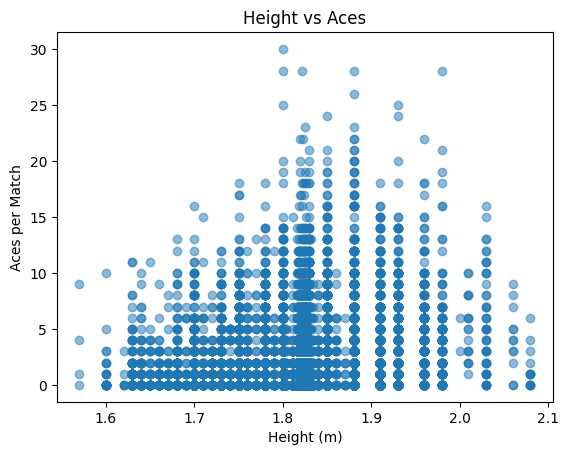


🎾 Average Aces per Height Bucket:
height_bucket
(1.6, 1.75]     1.764753
(1.75, 1.85]    1.672958
(1.85, 1.95]    3.089197
(1.95, 2.1]     3.854027
Name: aces, dtype: float64

✋ Average Aces per Handedness:
plays
left-handed     2.449527
right-handed    2.354473
unknown         1.522899
Name: aces, dtype: float64


C:\Users\omidw\AppData\Local\Temp\ipykernel_11572\1413181414.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(merged_all.groupby("height_bucket")["aces"].mean())


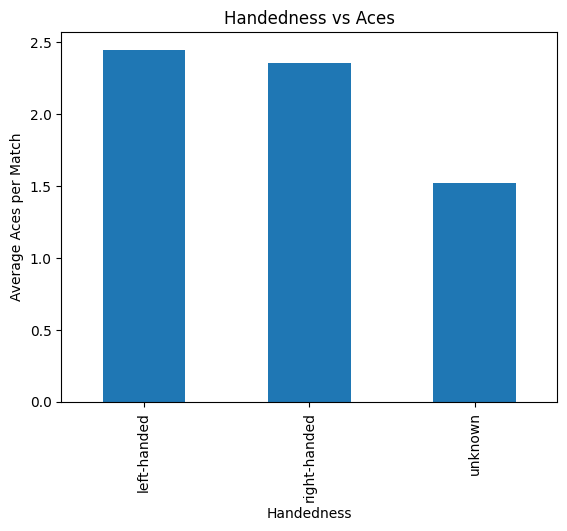

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# مسیر فایل نهایی
file_path = r"C:\Users\omidw\Desktop\Cleaned_data\Cleaned_frame\final_cleaned_data.parquet"

# فقط ستون‌های موردنیاز
df = pd.read_parquet(file_path, columns=[
    "match_id","player_id","full_name","height","plays","statistic_name",
    "home_value","away_value"
])

# -----------------------------
# استخراج آمار Aces
aces = df[df["statistic_name"].str.lower() == "aces"].copy()
aces["home_aces"] = aces["home_value"].fillna(0)
aces["away_aces"] = aces["away_value"].fillna(0)

# اطلاعات بازیکنان
players = df[["match_id","player_id","full_name","height","plays"]] \
    .dropna(subset=["player_id","height"]).drop_duplicates()

# join روی match_id
merged = pd.merge(players, aces[["match_id","home_aces","away_aces"]],
                  on="match_id", how="inner")

# فرض: اولین بازیکن = home, دومین بازیکن = away
merged_home = merged.groupby("match_id").nth(0).assign(aces=lambda d: d["home_aces"])
merged_away = merged.groupby("match_id").nth(1).assign(aces=lambda d: d["away_aces"])
merged_all = pd.concat([merged_home, merged_away])

# -----------------------------
# 1. Height ↔ Aces
corr_height_aces = merged_all["height"].corr(merged_all["aces"])
print("📏 Correlation between Height and Aces:", corr_height_aces)

# Scatter plot
plt.scatter(merged_all["height"], merged_all["aces"], alpha=0.5)
plt.xlabel("Height (m)")
plt.ylabel("Aces per Match")
plt.title("Height vs Aces")
plt.show()

# Bucket analysis
merged_all["height_bucket"] = pd.cut(merged_all["height"], bins=[1.60,1.75,1.85,1.95,2.10])
print("\n🎾 Average Aces per Height Bucket:")
print(merged_all.groupby("height_bucket")["aces"].mean())

# -----------------------------
# 2. Handedness ↔ Aces
avg_aces_by_hand = merged_all.groupby("plays")["aces"].mean().sort_values(ascending=False)
print("\n✋ Average Aces per Handedness:")
print(avg_aces_by_hand)

# Bar chart
avg_aces_by_hand.plot(kind="bar")
plt.xlabel("Handedness")
plt.ylabel("Average Aces per Match")
plt.title("Handedness vs Aces")
plt.show()